Trisha Manandhar
0369859

In [1]:
# Imports 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, confusion_matrix
from sklearn.dummy import DummyRegressor
from joblib import Parallel, delayed
import warnings
warnings.filterwarnings('ignore')

In [3]:
#Load dataset
df = pd.read_csv('wildfire.csv')
print("Data Shape:", df.shape)
df.head()

Data Shape: (55367, 43)


,Unnamed: 0.1,Unnamed: 0,fire_name,fire_size,fire_size_class,stat_cause_descr,latitude,longitude,state,disc_clean_date,...,Wind_cont,Hum_pre_30,Hum_pre_15,Hum_pre_7,Hum_cont,Prec_pre_30,Prec_pre_15,Prec_pre_7,Prec_cont,remoteness
0,0,0,NaN,10.0,C,Missing/Undefined,18.105072,-66.753044,PR,2/11/2007,...,3.250413,78.216590,76.793750,76.381579,78.724370,0.0,0.0,0.0,0.0,0.017923
1,1,1,NaN,3.0,B,Arson,35.038330,-87.610000,TN,12/11/2006,...,2.122320,70.840000,65.858911,55.505882,81.682678,59.8,8.4,0.0,86.8,0.184355
2,2,2,NaN,60.0,C,Arson,34.947800,-88.722500,MS,2/29/2004,...,3.369050,75.531629,75.868613,76.812834,65.063800,168.8,42.2,18.1,124.5,0.194544
3,3,3,WNA 1,1.0,B,Debris Burning,39.641400,-119.308300,NV,6/6/2005,...,0.000000,44.778429,37.140811,35.353846,0.000000,10.4,7.2,0.0,0.0,0.487447
4,4,4,NaN,2.0,B,Miscellaneous,30.700600,-90.591400,LA,9/22/1999,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.0,-1.0,-1.0,0.214633


In [5]:
print('Columns:', df.columns.tolist())

Columns: ['Unnamed: 0.1', 'Unnamed: 0', 'fire_name', 'fire_size', 'fire_size_class', 'stat_cause_descr', 'latitude', 'longitude', 'state', 'disc_clean_date', 'cont_clean_date', 'discovery_month', 'disc_date_final', 'cont_date_final', 'putout_time', 'disc_date_pre', 'disc_pre_year', 'disc_pre_month', 'wstation_usaf', 'dstation_m', 'wstation_wban', 'wstation_byear', 'wstation_eyear', 'Vegetation', 'fire_mag', 'weather_file', 'Temp_pre_30', 'Temp_pre_15', 'Temp_pre_7', 'Temp_cont', 'Wind_pre_30', 'Wind_pre_15', 'Wind_pre_7', 'Wind_cont', 'Hum_pre_30', 'Hum_pre_15', 'Hum_pre_7', 'Hum_cont', 'Prec_pre_30', 'Prec_pre_15', 'Prec_pre_7', 'Prec_cont', 'remoteness']


In [65]:
print("\nBasic Info:")
print(df.info())

print("\nSummary Statistics:")
print(df.describe())


Basic Info:
<class 'pandas.core.frame.DataFrame'>
Index: 18918 entries, 3 to 55351
Data columns (total 40 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   fire_size         18918 non-null  float64
 1   fire_size_class   18918 non-null  object 
 2   stat_cause_descr  18918 non-null  int64  
 3   latitude          18918 non-null  float64
 4   longitude         18918 non-null  float64
 5   state             18918 non-null  int64  
 6   cont_clean_date   18918 non-null  object 
 7   discovery_month   18918 non-null  object 
 8   disc_date_final   18918 non-null  object 
 9   cont_date_final   18918 non-null  object 
 10  putout_time       18918 non-null  object 
 11  disc_date_pre     18918 non-null  object 
 12  disc_pre_year     18918 non-null  int64  
 13  disc_pre_month    18918 non-null  object 
 14  wstation_usaf     18918 non-null  object 
 15  dstation_m        18918 non-null  float64
 16  wstation_wban     18918 non-null

In [7]:
# Datacleaning
df.drop(columns=['Unnamed: 0', 'Unnamed: 0.1', 'fire_name', 'disc_clean_date'], errors='ignore', inplace=True)
df.replace(-1.0, np.nan, inplace=True)
df.dropna(inplace=True)

In [9]:
#Categorical encoding
df['stat_cause_descr'] = pd.factorize(df['stat_cause_descr'])[0]
df['state'] = pd.factorize(df['state'])[0]

In [11]:
# Feature Engineering
X = df.drop(columns=['fire_size'])
y = df['fire_size']
X = X.select_dtypes(include=[np.number])

In [13]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
#Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [17]:
# Model 1: Linear Regression
lr_model = LinearRegression()
start = time.time()
lr_model.fit(X_train_scaled, y_train)
lr_train_time = time.time() - start
y_pred_lr = lr_model.predict(X_test_scaled)

In [19]:
# Model 2: Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, max_depth=20, random_state=42, n_jobs=-1)
start = time.time()
rf_model.fit(X_train_scaled, y_train)
rf_train_time = time.time() - start
y_pred_rf = rf_model.predict(X_test_scaled)

In [20]:
# Baseline: Dummy Regressor
dummy_model = DummyRegressor(strategy="mean")
start = time.time()
dummy_model.fit(X_train_scaled, y_train)
dummy_train_time = time.time() - start
y_dummy = dummy_model.predict(X_test_scaled)

In [23]:
# Evaluation Function
def evaluate_model(name, y_true, y_pred, train_time=None):
    print(f"\n {name}")
    print("MAE:", mean_absolute_error(y_true, y_pred))
    print("RMSE:", np.sqrt(mean_squared_error(y_true, y_pred)))
    print("R²:", r2_score(y_true, y_pred))
    if train_time:
        print(f"Training Time: {train_time:.4f} seconds")

In [25]:
# Evaluate Models
evaluate_model("Linear Regression", y_test, y_pred_lr, lr_train_time)
evaluate_model("Random Forest", y_test, y_pred_rf, rf_train_time)
evaluate_model("Dummy Regressor", y_test, y_dummy, dummy_train_time)


 Linear Regression
MAE: 4925.116963320564
RMSE: 16575.806397551492
R²: 0.24124971667218387
Training Time: 0.3835 seconds

 Random Forest
MAE: 3553.1760385430775
RMSE: 15613.97228539606
R²: 0.3267500290362758
Training Time: 12.7714 seconds

 Dummy Regressor
MAE: 6822.52938940741
RMSE: 19033.2988441466
R²: -0.00040917974944720825
Training Time: 0.0029 seconds


In [27]:
# OLS Summary
X_train_ols = sm.add_constant(X_train_scaled)
ols = sm.OLS(y_train, X_train_ols).fit()
print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:              fire_size   R-squared:                       0.209
Model:                            OLS   Adj. R-squared:                  0.207
Method:                 Least Squares   F-statistic:                     142.2
Date:                Thu, 17 Jul 2025   Prob (F-statistic):               0.00
Time:                        12:31:50   Log-Likelihood:            -1.7125e+05
No. Observations:               15134   AIC:                         3.426e+05
Df Residuals:                   15105   BIC:                         3.428e+05
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4468.6443    161.668     27.641      0.0

In [29]:
# Parallel Computing – Simulation
def simulate_training(delay=1):
    time.sleep(delay)
    return delay

seq_start = time.time()
for _ in range(5):
    simulate_training(1)
seq_time = time.time() - seq_start

par_start = time.time()
Parallel(n_jobs=5)(delayed(simulate_training)(1) for _ in range(5))
par_time = time.time() - par_start

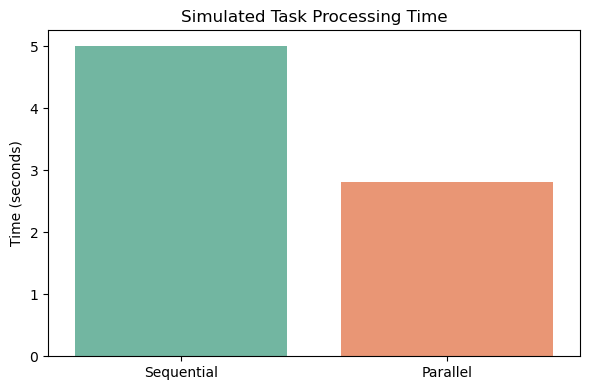

In [30]:
# Compare Sequential vs Parallel
plt.figure(figsize=(6, 4))
sns.barplot(x=['Sequential', 'Parallel'], y=[seq_time, par_time], palette='Set2')
plt.title("Simulated Task Processing Time")
plt.ylabel("Time (seconds)")
plt.tight_layout()
plt.show()

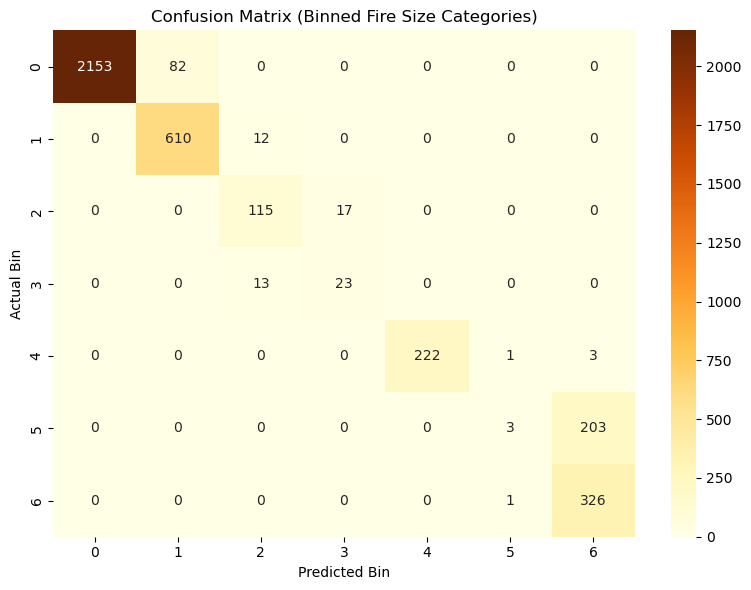

In [33]:
# Confusion Matrix-like View (Regression Binning)
bins = [0, 10, 100, 500, 1000, 5000, 10000, np.inf]
y_test_binned = pd.cut(y_test, bins=bins, labels=False)
y_pred_binned = pd.cut(y_pred_rf, bins=bins, labels=False)
cm = confusion_matrix(y_test_binned, y_pred_binned)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlOrBr')
plt.title("Confusion Matrix (Binned Fire Size Categories)")
plt.xlabel("Predicted Bin")
plt.ylabel("Actual Bin")
plt.tight_layout()
plt.show()

In [35]:
# Parallel Training of Multiple Models
def train_one_model(seed):
    model = RandomForestRegressor(n_estimators=50, max_depth=10, random_state=seed)
    model.fit(X_train_scaled, y_train)
    return model.score(X_test_scaled, y_test)

scores = Parallel(n_jobs=4)(delayed(train_one_model)(s) for s in range(4))
print("Parallel RF Models R²:", scores)
print("Average R²:", np.mean(scores))

Parallel RF Models R²: [0.3362560144763683, 0.3318771302019403, 0.29202003162291357, 0.3216524678166113]
Average R²: 0.3204514110294584


In [36]:
# Grid Search
param_grid = {'n_estimators': [50, 100], 'max_depth': [10, 20]}
grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=3, n_jobs=-1)
start = time.time()
grid_search.fit(X_train_scaled, y_train)
end = time.time()
print("Grid Best Params:", grid_search.best_params_)
print("Best CV R²:", grid_search.best_score_)
print("Grid Search Time:", round(end - start, 2), "seconds")

Grid Best Params: {'max_depth': 10, 'n_estimators': 100}
Best CV R²: 0.2389664115468015
Grid Search Time: 120.28 seconds


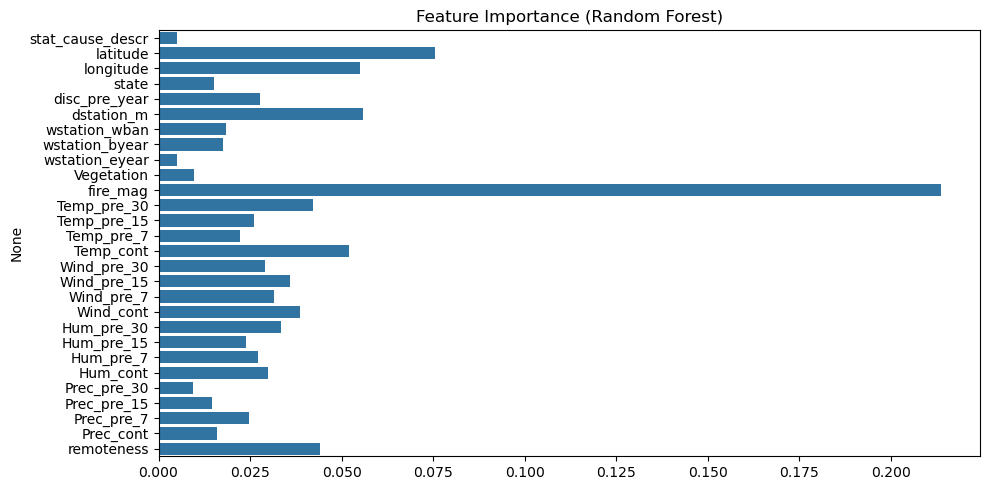

In [37]:
# Feature Importance
feature_importances = rf_model.feature_importances_
features = X.columns
plt.figure(figsize=(10, 5))
sns.barplot(x=feature_importances, y=features)
plt.title("Feature Importance (Random Forest)")
plt.tight_layout()
plt.show()

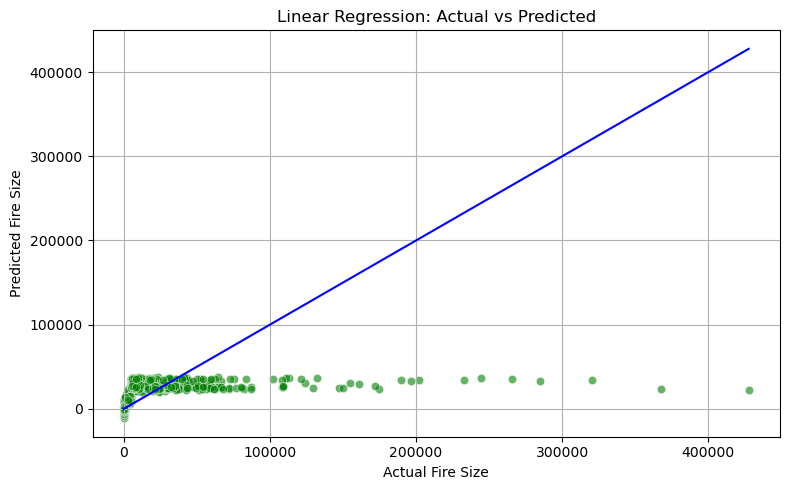

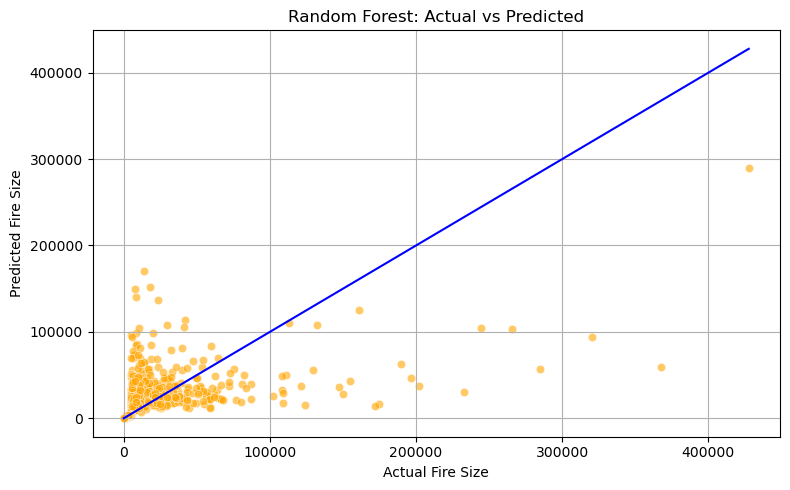

In [38]:
# Actual vs Predicted Plots
def plot_actual_vs_predicted(y_true, y_pred, title, color):
    plt.figure(figsize=(8, 5))
    sns.scatterplot(x=y_true, y=y_pred, alpha=0.6, color=color)
    sns.lineplot(x=y_true, y=y_true, color='blue')
    plt.title(title)
    plt.xlabel("Actual Fire Size")
    plt.ylabel("Predicted Fire Size")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_actual_vs_predicted(y_test, y_pred_lr, "Linear Regression: Actual vs Predicted", "green")
plot_actual_vs_predicted(y_test, y_pred_rf, "Random Forest: Actual vs Predicted", "orange")

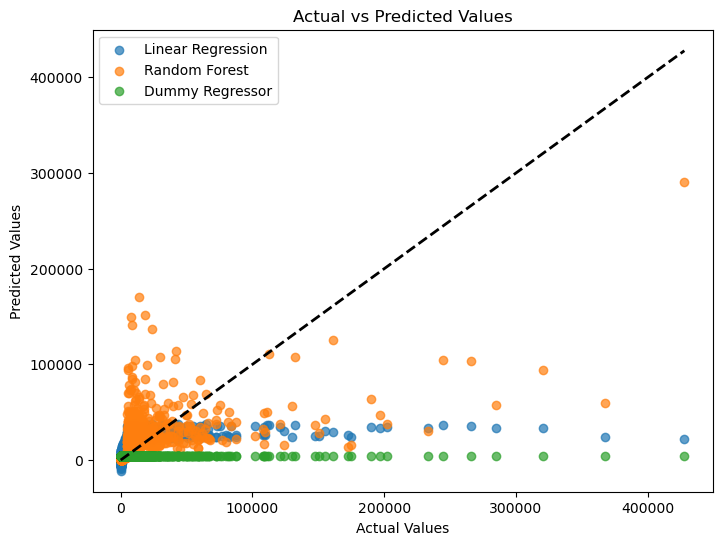

In [42]:
#Scatter plot comparing actual vs predicted values for each model.
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred_lr, alpha=0.7, label='Linear Regression')
plt.scatter(y_test, y_pred_rf, alpha=0.7, label='Random Forest')
plt.scatter(y_test, y_dummy, alpha=0.7, label='Dummy Regressor')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'k--', lw=2)  # diagonal line for perfect prediction
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted Values")
plt.legend()
plt.show()

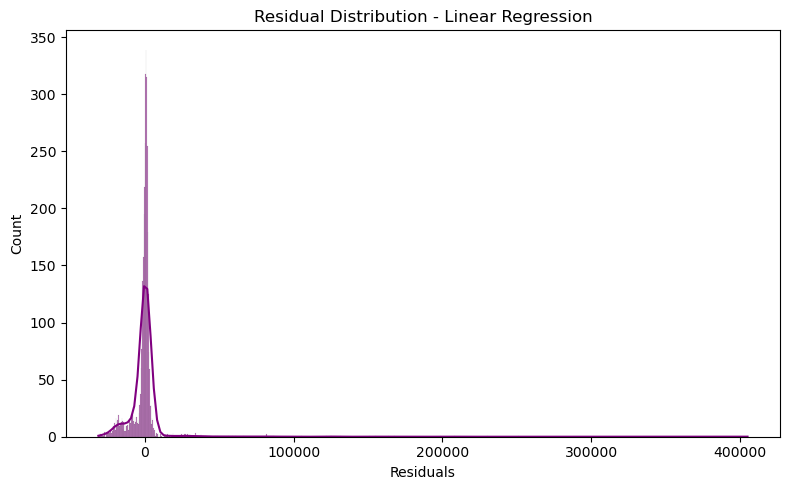

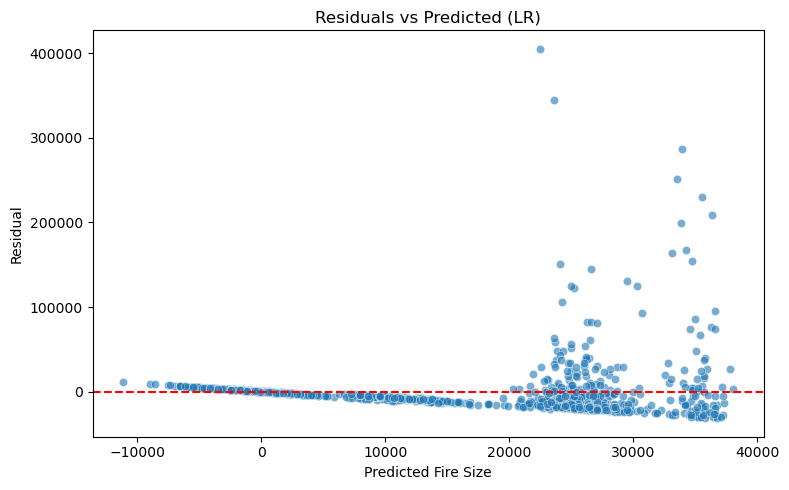

In [45]:
# Linear Regression Residual Plot
residuals_lr = y_test - lr_model.predict(X_test_scaled)

plt.figure(figsize=(8, 5))
sns.histplot(residuals_lr, kde=True, color='purple')
plt.title("Residual Distribution - Linear Regression")
plt.xlabel("Residuals")
plt.tight_layout()
plt.show()

# Residuals vs Predicted
plt.figure(figsize=(8, 5))
sns.scatterplot(x=lr_model.predict(X_test_scaled), y=residuals_lr, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs Predicted (LR)")
plt.xlabel("Predicted Fire Size")
plt.ylabel("Residual")
plt.tight_layout()
plt.show()

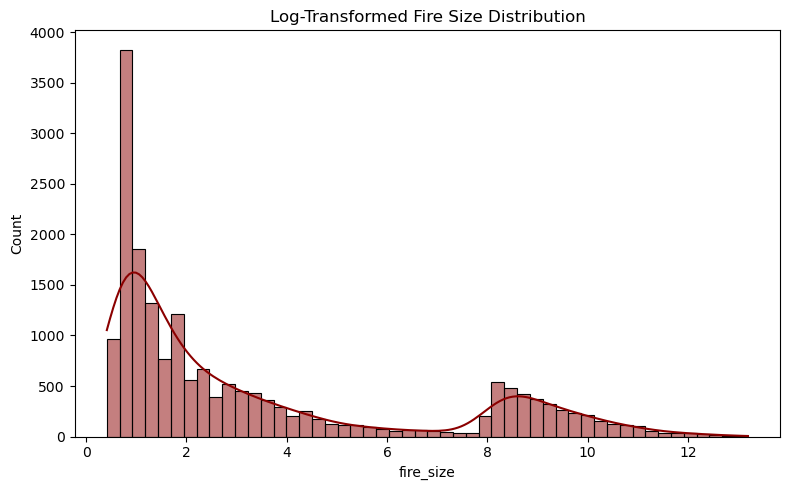

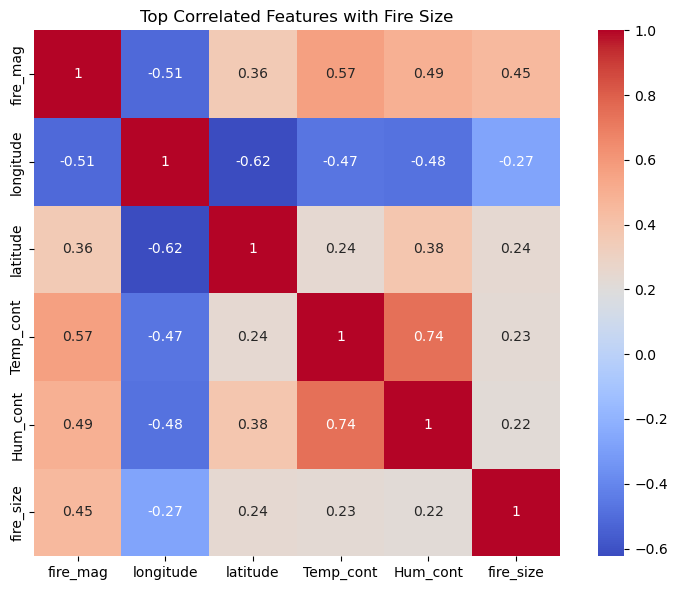

In [47]:
# Distribution & Correlation
plt.figure(figsize=(8, 5))
sns.histplot(np.log1p(df['fire_size']), bins=50, kde=True, color='darkred')
plt.title("Log-Transformed Fire Size Distribution")
plt.tight_layout()
plt.show()

corr = df.select_dtypes(include=[np.number]).corr()
top_corr = corr['fire_size'].abs().sort_values(ascending=False).index[1:6].tolist() + ['fire_size']
plt.figure(figsize=(8, 6))
sns.heatmap(corr.loc[top_corr, top_corr], annot=True, cmap='coolwarm', square=True)
plt.title("Top Correlated Features with Fire Size")
plt.tight_layout()
plt.show()

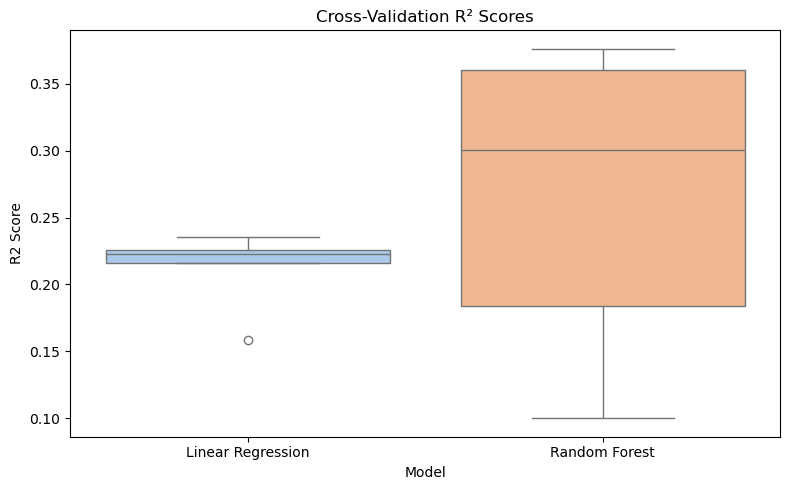

In [48]:
# Cross-validation Scores
cv_scores_lr = cross_val_score(lr_model, X_train_scaled, y_train, cv=5, scoring='r2')
cv_scores_rf = cross_val_score(rf_model, X_train_scaled, y_train, cv=5, scoring='r2')

cv_df = pd.DataFrame({
    'Model': ['Linear Regression'] * 5 + ['Random Forest'] * 5,
    'Fold': list(range(1, 6)) * 2,
    'R2 Score': list(cv_scores_lr) + list(cv_scores_rf)
})

plt.figure(figsize=(8, 5))
sns.boxplot(data=cv_df, x='Model', y='R2 Score', palette='pastel')
plt.title("Cross-Validation R² Scores")
plt.tight_layout()
plt.show()

In [50]:
#Model Comparison Table
print("\nModel Comparison Table:")
print(f"{'Model':<20}{'MAE':<10}{'RMSE':<10}{'R²':<10}{'Train Time(s)':<15}")
print(f"{'Linear Regression':<20}{mean_absolute_error(y_test, y_pred_lr):<10.2f}{np.sqrt(mean_squared_error(y_test, y_pred_lr)):<10.2f}{r2_score(y_test, y_pred_lr):<10.2f}{lr_train_time:<15.4f}")
print(f"{'Random Forest':<20}{mean_absolute_error(y_test, y_pred_rf):<10.2f}{np.sqrt(mean_squared_error(y_test, y_pred_rf)):<10.2f}{r2_score(y_test, y_pred_rf):<10.2f}{rf_train_time:<15.4f}")
print(f"{'Dummy Regressor':<20}{mean_absolute_error(y_test, y_dummy):<10.2f}{np.sqrt(mean_squared_error(y_test, y_dummy)):<10.2f}{'N/A':<10}{dummy_train_time:<15.4f}")


Model Comparison Table:
Model               MAE       RMSE      R²        Train Time(s)  
Linear Regression   4925.12   16575.81  0.24      0.3835         
Random Forest       3553.18   15613.97  0.33      12.7714        
Dummy Regressor     6822.53   19033.30  N/A       0.0029         


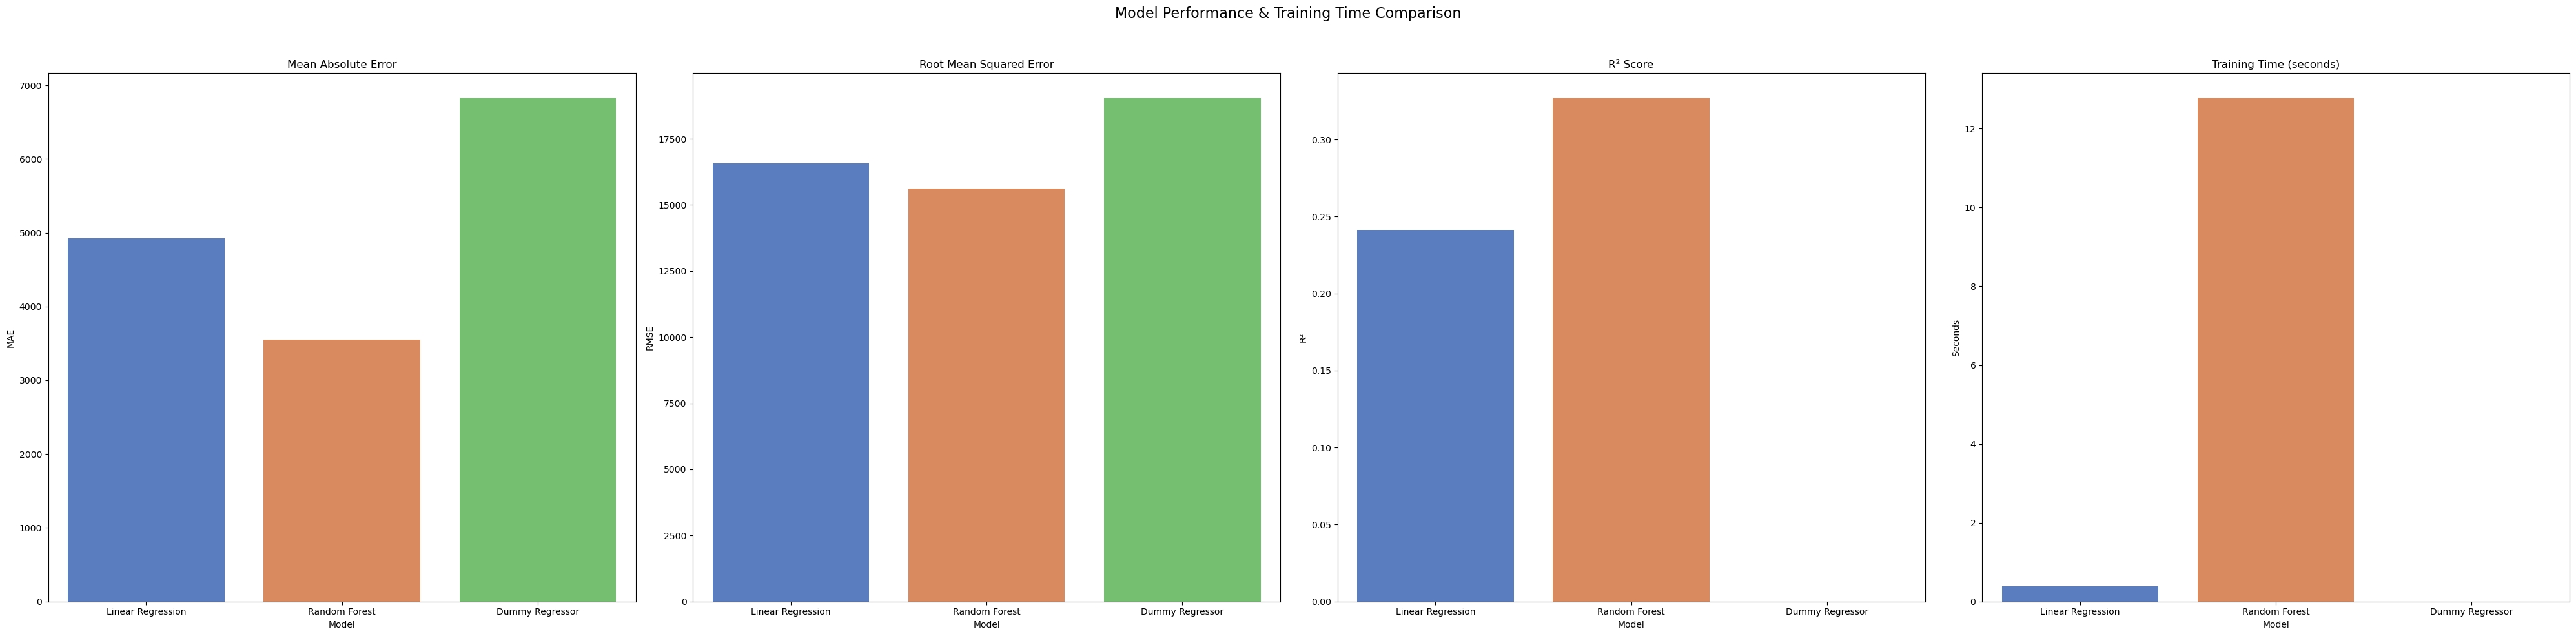

In [51]:
# Model Comparison Visualization
metrics_df = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest', 'Dummy Regressor'],
    'MAE': [
        mean_absolute_error(y_test, y_pred_lr),
        mean_absolute_error(y_test, y_pred_rf),
        mean_absolute_error(y_test, y_dummy)
    ],
    'RMSE': [
        np.sqrt(mean_squared_error(y_test, y_pred_lr)),
        np.sqrt(mean_squared_error(y_test, y_pred_rf)),
        np.sqrt(mean_squared_error(y_test, y_dummy))
    ],
    'R2': [
        r2_score(y_test, y_pred_lr),
        r2_score(y_test, y_pred_rf),
        np.nan  
    ],
    'Train Time (s)': [lr_train_time, rf_train_time, dummy_train_time]
})

fig, axs = plt.subplots(1, 4, figsize=(40, 10))

sns.barplot(x='Model', y='MAE', data=metrics_df, ax=axs[0], palette='muted')
axs[0].set_title("Mean Absolute Error")
axs[0].set_ylabel("MAE")

sns.barplot(x='Model', y='RMSE', data=metrics_df, ax=axs[1], palette='muted')
axs[1].set_title("Root Mean Squared Error")
axs[1].set_ylabel("RMSE")

sns.barplot(x='Model', y='R2', data=metrics_df, ax=axs[2], palette='muted')
axs[2].set_title("R² Score")
axs[2].set_ylabel("R²")

sns.barplot(x='Model', y='Train Time (s)', data=metrics_df, ax=axs[3], palette='muted')
axs[3].set_title("Training Time (seconds)")
axs[3].set_ylabel("Seconds")

plt.suptitle("Model Performance & Training Time Comparison", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

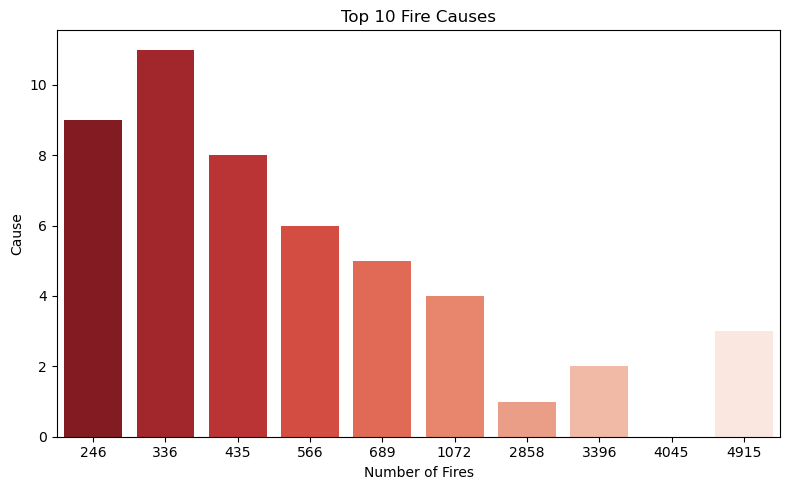

In [52]:
# Top 10 Fire Causes
cause_counts = df['stat_cause_descr'].value_counts().head(10)
plt.figure(figsize=(8, 5))
sns.barplot(x=cause_counts.values, y=cause_counts.index, palette='Reds_r')
plt.title("Top 10 Fire Causes")
plt.xlabel("Number of Fires")
plt.ylabel("Cause")
plt.tight_layout()
plt.show()

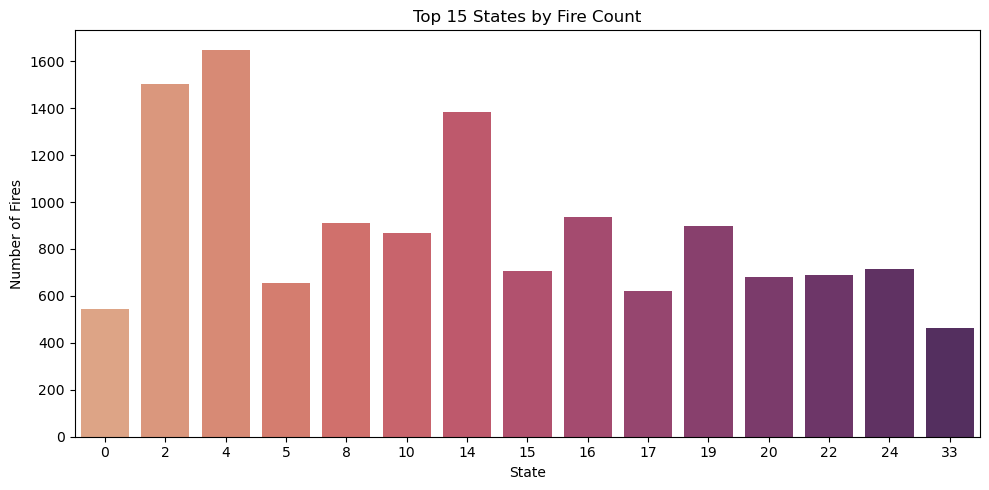

In [53]:
#Fire by states
state_counts = df['state'].value_counts().head(15)
plt.figure(figsize=(10, 5))
sns.barplot(x=state_counts.index, y=state_counts.values, palette='flare')
plt.title("Top 15 States by Fire Count")
plt.xlabel("State")
plt.ylabel("Number of Fires")
plt.tight_layout()
plt.show()

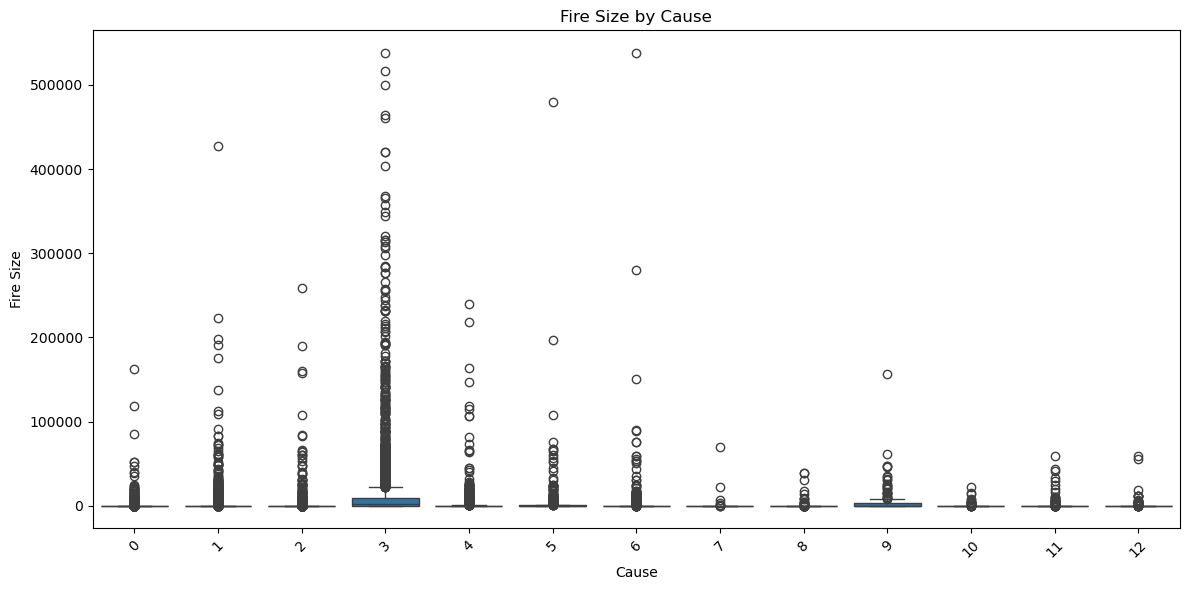

In [54]:
#Fire size by cause
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='stat_cause_descr', y='fire_size')
plt.title("Fire Size by Cause")
plt.xlabel("Cause")
plt.ylabel("Fire Size")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

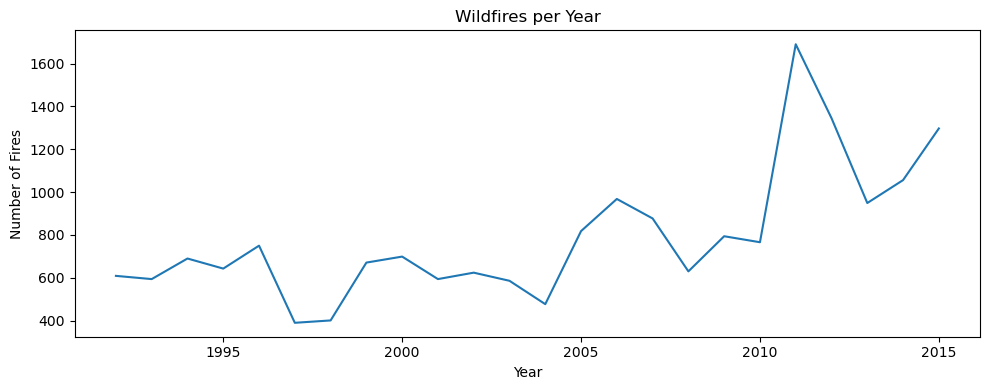

In [55]:
# Temporal Analysis: Fires by Year
df['year'] = pd.to_datetime(df['disc_date_final']).dt.year
fires_per_year = df['year'].value_counts().sort_index()
plt.figure(figsize=(10, 4))
sns.lineplot(x=fires_per_year.index, y=fires_per_year.values)
plt.title("Wildfires per Year")
plt.xlabel("Year")
plt.ylabel("Number of Fires")
plt.tight_layout()
plt.show()

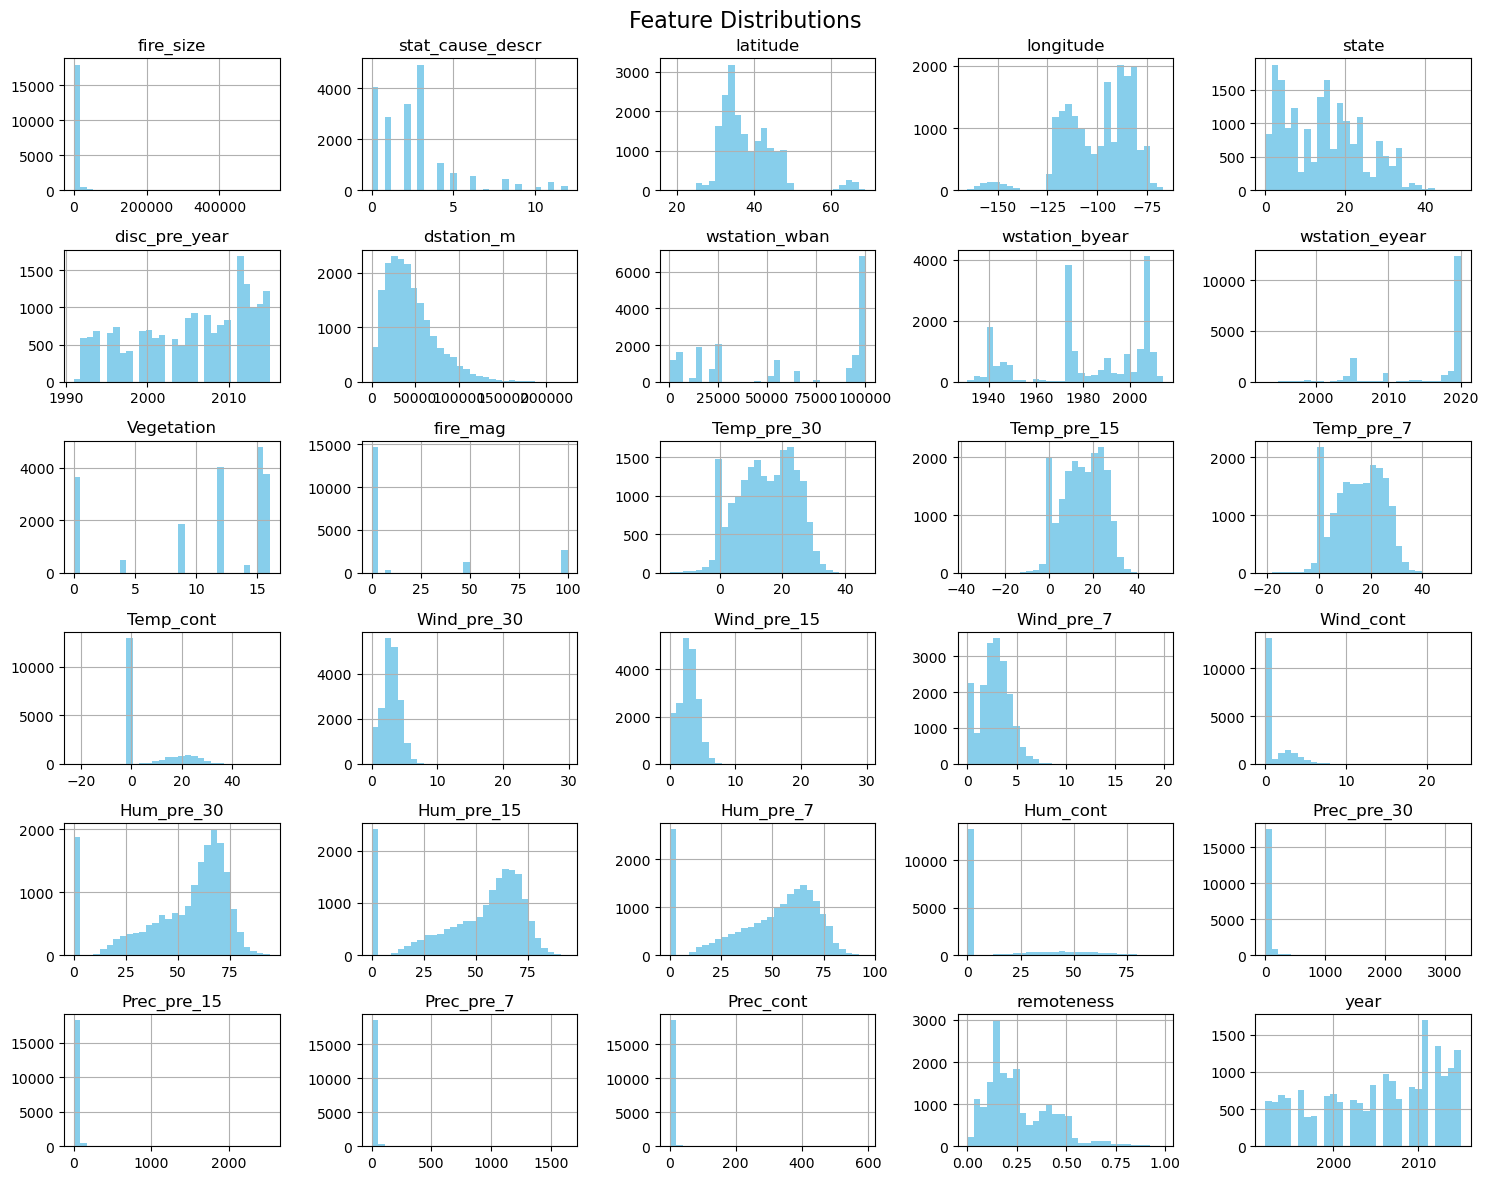

In [56]:
#Feature Distribution
numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
df[numeric_cols].hist(figsize=(15, 12), bins=30, color='skyblue')
plt.suptitle("Feature Distributions", fontsize=16)
plt.tight_layout()
plt.show()